# Wall following behavior
Multiclass classification using the 2 readings dataset from the website: https://www.kaggle.com/uciml/wall-following-robot


### Load drive
This code is needed to load the drive where the dataset is stored

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries
Here all the libraries needed to run the code are initialized

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### READ DATA
Here data are read from the csv file and they are stored in format numpy in order to be easily manipulated later.

In [2]:
Data = pd.read_csv('drive/MyDrive/ML2022/sensor_readings_2.csv')
D=Data.to_numpy()
dim=np.shape(D)
print(dim)
DF=np.copy(D)

(5456, 3)


### DATA PREPROCESSING
The matrix we found is a matrix containing 2 colums of integers representing the distance read from each sensor and one column for the correct classification. In order to do multiclass classification we change the classification column by giving numeric symbols to represent the class. This is not properly correct since there shouldn't be the notion of distance in a classification problem.

In [3]:
DF = np.where(DF == 'Move-Forward' , 0, DF)
DF = np.where(DF == 'Sharp-Right-Turn', 1, DF)
DF = np.where(DF == 'Slight-Left-Turn' , 2, DF)
DF = np.where(DF == 'Slight-Right-Turn', 3, DF)

### EDA- Exploratory Data Analysis
We want to visually represent the data we are working with to understand the format and the meaning.

In the following block we randomly find an entry that is classified as 'Moving-Forward'. The 2 distances will be represented as coordinates of points and each point will be a different color depending on the classifications, red points will correspond to measuraments when the robot turns sharply to the right while blue points will be measurement when the robot moves forward, green points will be when the robot turns slightly to the left, yellow points when the robot move slightly to the right.

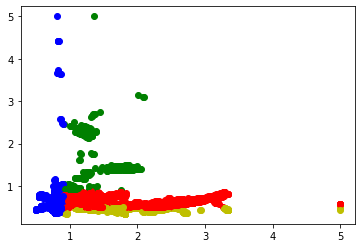

In [4]:
fig, ax = plt.subplots()
for i in range(np.shape(DF)[0]):
  if DF[i,2]== 0:
    ax.plot(DF[i,0],DF[i,1],'ro')
  elif DF[i,2]== 1:
    ax.plot(DF[i,0],DF[i,1],'bo')
  elif DF[i,2]== 2:
    ax.plot(DF[i,0],DF[i,1],'go')
  elif DF[i,2]== 3:
    ax.plot(DF[i,0],DF[i,1],'yo')

### Data Preprocessing
In this block we randomly divide the dataset in Learning ( X and Y) and Testing ( XT and YT). The percentage of entries to be put in the learning set can be set while calculating il. That is the only parameter that can be decided, the actual division will be done in a random way.

In [5]:
dim=np.shape(DF)
print(dim)
il=round(0.85*dim[0])
i=np.random.permutation(dim[0])
X=DF[i[0:il],0:dim[1]-1]
Y=DF[i[0:il],dim[1]-1]
Y=Y.astype('int')
XT=DF[i[il+1:dim[0]],0:dim[1]-1]
YT=DF[i[il+1:dim[0]],dim[1]-1]
YT=YT.astype('int')


(5456, 3)


### NORMALIZE DATA
With this code we normalize the data, we want to have the inputs in a standard interval from 0 to 1. To be noted that we calculate the transformation on the Learning Set and we apply the same transformation to the Test Set.

In [6]:
scalerX = preprocessing.MinMaxScaler()
X = scalerX.fit_transform(X)
XT = scalerX.transform(XT)

#### HYPERPARAMETER GRID SEARCH - SVC
Here we look for the best hyperparameter ( C, gamma ) for the Learning set. We do not need to divide into Learning and Validation set because we apply a k-fold cross validation, in this case 10-fold.

In [7]:
grid = {'C':        np.logspace(-4,3,5),
        'kernel':   ['rbf'],
        'gamma':    np.logspace(-4,3,5)}
MS = GridSearchCV(estimator = SVC(),
                  param_grid = grid,
                  scoring = 'balanced_accuracy',
                  cv = 10,
                  verbose = 0)
H = MS.fit(X,Y)

### TRAIN MODEL - SVC
Here, using the best hyperparameters we find the model to represent our data, the model we will use to predict the results.

In [8]:
M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'],
        gamma = H.best_params_['gamma'])
M.fit(X,Y)

SVC(C=1000.0, gamma=17.78279410038923)

### TEST - SVC
Here we use the Test Set to evaluate our model, we predict using XT and we compare the results obtained (YF) with the true results (YT) using a confusion matrix. In the row we have what we predicted and in the columns the true result.

In [9]:
YF = M.predict(XT)
confusion_matrix(YT,YF)

array([[342,   0,   0,   1],
       [  0, 307,   0,   0],
       [  0,   0,  48,   0],
       [  1,   1,   0, 117]])

### Show the results
Since this dataset is simpler then the other two we are able to show on a plot the result of the classification of the test set. In this plot we have all of the correctly classified points.

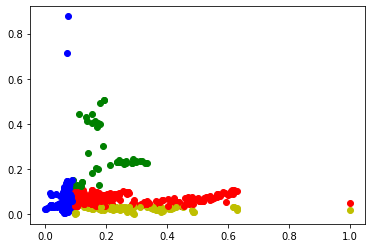

In [10]:
fig, ax = plt.subplots()
for i in range(np.shape(YF)[0]):
  if YF[i]==YT[i] and YT[i]==1:
    ax.plot(XT[i,0],XT[i,1],'bo')
  elif YF[i]==YT[i] and YT[i]==0:
    ax.plot(XT[i,0],XT[i,1],'ro')
  elif YF[i]==YT[i] and YT[i]==2:
    ax.plot(XT[i,0],XT[i,1],'go')
  elif YF[i]==YT[i] and YT[i]==3:
    ax.plot(XT[i,0],XT[i,1],'yo')

In this plot we have all of the wrongly classified points, in red the points that should have been classified as Move-Forward, in blue the points that should have been classified as Sharp-Righ-Turn, in green the points that should have been classified as Slight-Left-Turn and yellow points if Slight-Right-Turn.

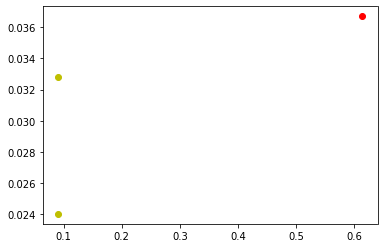

In [11]:
fig, ax = plt.subplots()
for i in range(np.shape(YF)[0]):
  if YF[i]!=YT[i] and YT[i]==1:
    ax.plot(XT[i,0],XT[i,1],'bo')
  elif YF[i]!=YT[i] and YT[i]==0:
    ax.plot(XT[i,0],XT[i,1],'ro')
  elif YF[i]!=YT[i] and YT[i]==2:
    ax.plot(XT[i,0],XT[i,1],'go')
  elif YF[i]!=YT[i] and YT[i]==3:
    ax.plot(XT[i,0],XT[i,1],'yo')

### HYPERPARAMETER GRID SEARCH - Tree Classifier
Here we look for the best hyperparameter (min_samples_leaf) for the Learning set. We do not need to divide into Learning and Validation set because we apply a k-fold cross validation, in this case 10-fold.

In [12]:
maxDepth=3
grid = {'min_samples_leaf': [8,16,32,64,96,128]}
MS = GridSearchCV(estimator = DecisionTreeClassifier(),
                  param_grid = grid,
                  scoring = 'neg_mean_absolute_error',
                  cv = 10,
                  verbose = 0)
H = MS.fit(X,Y)

### TRAIN MODEL - Tree Classifier
Here, using the best hyperparameters we find the model to represent our data, the model we will use to predict the results.

In [13]:
M = DecisionTreeClassifier(min_samples_leaf=H.best_params_['min_samples_leaf'],
                           max_depth=maxDepth)
M.fit(X,Y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=8)

Represent the tree obtained as text

In [14]:
text_representation = tree.export_text(M)
print(text_representation)

|--- feature_0 <= 0.09
|   |--- class: 1
|--- feature_0 >  0.09
|   |--- feature_1 <= 0.03
|   |   |--- class: 3
|   |--- feature_1 >  0.03
|   |   |--- feature_1 <= 0.12
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.12
|   |   |   |--- class: 2



Represent the tree in a visual way, as a graph.

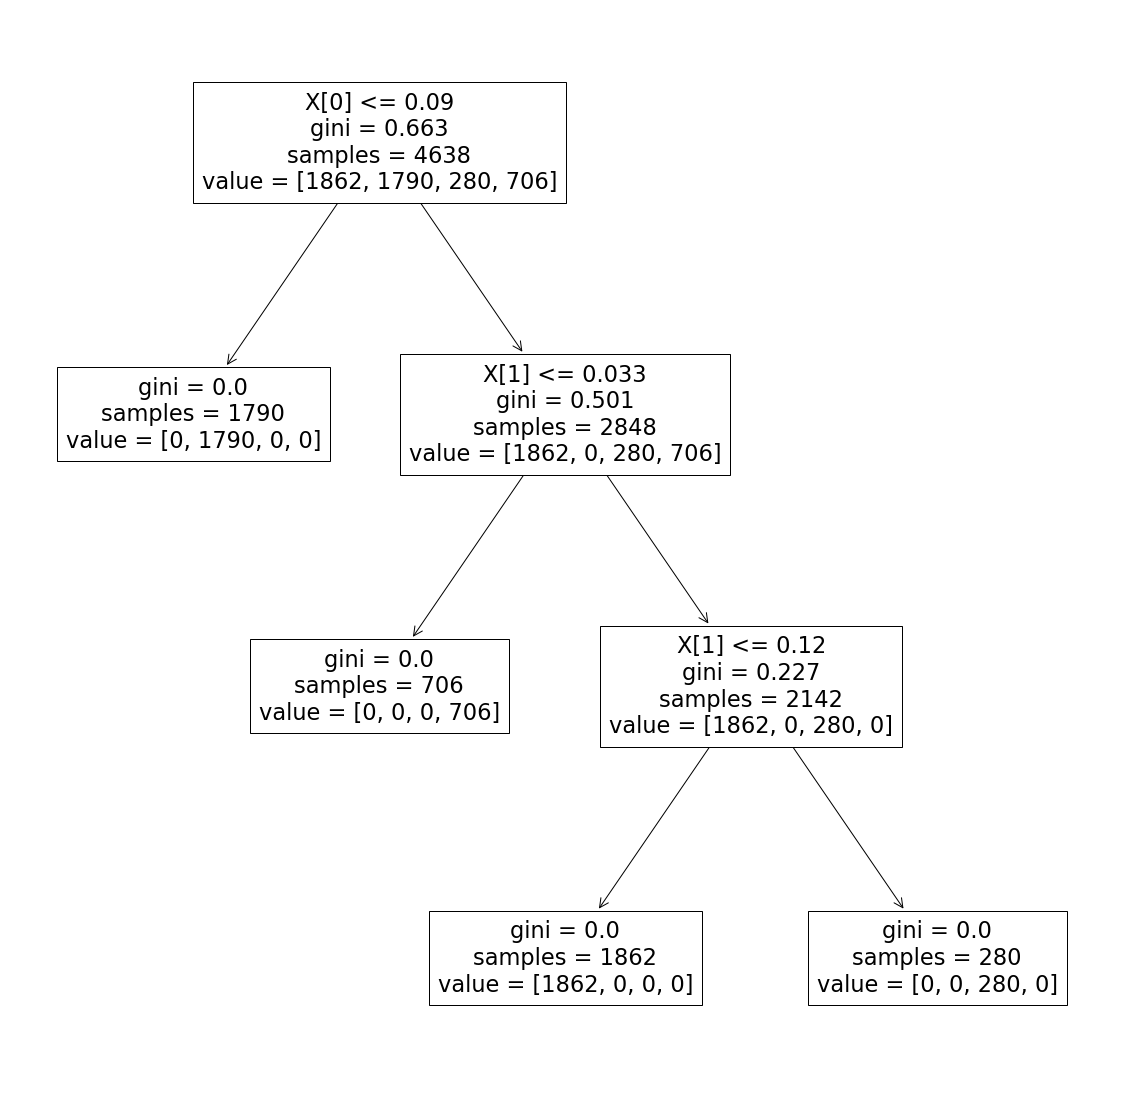

In [15]:
fig = plt.figure(figsize=(20,20))
_ = tree.plot_tree(M)

### TEST - Tree Classifier
Here we use the Test Set to evaluate our model, we predict using XT and we compare the results obtained (YF) with the true results (YT) using a confusion matrix. In the row we have what we predicted and in the columns the true result.

In [16]:
YF = M.predict(XT)
confusion_matrix(YT,YF)

array([[343,   0,   0,   0],
       [  0, 307,   0,   0],
       [  0,   0,  48,   0],
       [  0,   0,   0, 119]])

### Show the results
Since this dataset is simpler then the other two we are able to show on a plot the result of the classification of the test set. In this plot we have all of the correctly classified points.

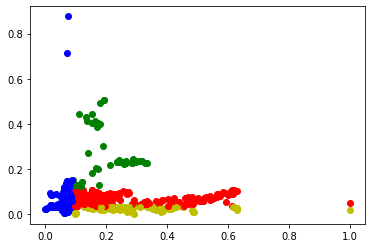

In [17]:
fig, ax = plt.subplots()
for i in range(np.shape(YF)[0]):
  if YF[i]==YT[i] and YT[i]==1:
    ax.plot(XT[i,0],XT[i,1],'bo')
  elif YF[i]==YT[i] and YT[i]==0:
    ax.plot(XT[i,0],XT[i,1],'ro')
  elif YF[i]==YT[i] and YT[i]==2:
    ax.plot(XT[i,0],XT[i,1],'go')
  elif YF[i]==YT[i] and YT[i]==3:
    ax.plot(XT[i,0],XT[i,1],'yo')

In this plot we have all of the wrongly classified points, in red the points that should have been classified as Move-Forward, in blue the points that should have been classified as Sharp-Righ-Turn, in green the points that should have been classified as Slight-Left-Turn and yellow points if Slight-Right-Turn.

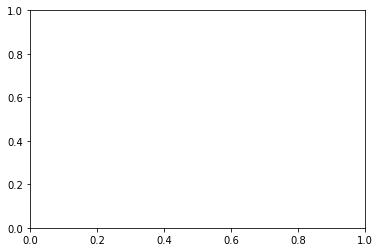

In [18]:
fig, ax = plt.subplots()
for i in range(np.shape(YF)[0]):
  if YF[i]!=YT[i] and YT[i]==1:
    ax.plot(XT[i,0],XT[i,1],'bo')
  elif YF[i]!=YT[i] and YT[i]==0:
    ax.plot(XT[i,0],XT[i,1],'ro')
  elif YF[i]!=YT[i] and YT[i]==2:
    ax.plot(XT[i,0],XT[i,1],'go')
  elif YF[i]!=YT[i] and YT[i]==3:
    ax.plot(XT[i,0],XT[i,1],'yo')